## 基于Pipeline的工作流

In [9]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
from sklearn.preprocessing import LabelEncoder
X= df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [12]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state = 1)

In [14]:
#在Pipeline中继承数据转换及评估操作

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#Pipeline对象采用Tuple作为输入，每个Tuple中的第一个值为一个字符串，可以是任意的标识符，
#通过它来访问Pipeline中的元素，第二个值则为scikitlearn中的一个转换器或者评估器
#自动执行fit和tranform操作
pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('pca',PCA(n_components=2)),
                    ('clf',LogisticRegression(random_state=1))
                   ])

pipe_lr.fit(X_train,y_train)
print('The Accuracy: %.3f' % pipe_lr.score(X_test,y_test))

The Accuracy: 0.947


## 使用K折交叉验证评估模型性能

In [29]:
#holdout方法
#k折交叉验证
#分层k折交叉验证对标准k折交叉验证做了稍许改进，类别比例在每个分块中得以保持
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train,n_folds=10,random_state=1)
scores=[]
for k,(train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score=pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' %(k+1,np.bincount(y_train[train]),score))

print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))


Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


In [32]:
#scikit-learn中也实现了k折交叉验证评分
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1) # n_jobs: 任务分布到n个cpu, n_jobs=-1,表示所有CPU并行计算
print('CV accuracy scores: %s',scores)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy scores: %s [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


## 通过学习及验证曲线来调试算法

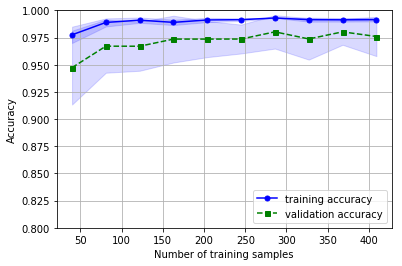

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression(penalty='l2',random_state=0))])
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr,
                                                     X=X_train,
                                                     y=y_train,
                                                     train_sizes = np.linspace(0.1,1.,10),
                                                     cv=10,
                                                     n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,
                train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='green',linestyle='--',
         marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,
                test_mean-test_std,alpha=0.15,color='blue')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

In [ ]:
#通过验证曲线来判定
from sklearn.learning_curve import validation_curve
param_range = [0.001,0.01,0.1,1,10,100]
